<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#[TODO]-정답-코드-구현-DeepLabv3-(VGG16)-" data-toc-modified-id="[TODO]-정답-코드-구현-DeepLabv3-(VGG16)--5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span><font color="blue">[TODO] 정답 코드 구현 DeepLabv3 (VGG16) </font></a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
sys.path.insert(0, '/opt/ml/code')
from utils import label_accuracy_score
from loss import *
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#K-fold
from sklearn.model_selection import StratifiedKFold

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

#속도 향상을 위해 설정
torch.backends.cudnn.benchmark = True

#wandb
import wandb

pytorch version: 1.7.1
GPU 사용 가능 여부: True
Tesla P40
1


## 하이퍼파라미터 세팅 및 seed 고정

In [2]:
#Model setting
model_name = "efficientnet-b4"
pretrained_name = "imagenet"
augmentation_type = "HF_Rt_Cout_RBC_Norm" #"RC_HF_RBC"
optimizer_name = "adam"
scheduler_name = "CosineAnnealingLR"
criterion_name = "CrossEntropy"
group_name = 'DeepLab3_kfold'

In [3]:
batch_size = 4   # Mini-batch size
test_batch_size = 5 #5/8
num_epochs = 5
learning_rate = 0.0001; adam_weight_decay = 1e-6; # 1e-6
n_splits = 5;# k-fold 분할 수, data file 분할 수
#steplr
#steplr_step_size=30; steplr_gamma=0.1
#CosineAnnealingLR
cos_T_max = 50; cos_eta_min = 0
#focal gamma
#focal_gamma = 0.2
# SoftCrossEntropyLoss
#softCross_smooth_factor=0.1; softCross_ignore_index= -100; softCross_dim=1

config = {"batch_size" : batch_size, "num_epochs" : num_epochs, "learning_rate" : learning_rate}
#steplr_config = {"batch_size" : batch_size, "num_epochs" : num_epochs, "learning_rate" : learning_rate, "steplr_step_size" : steplr_step_size, "steplr_gamma":steplr_gamma}
cosine_config = {"batch_size" : batch_size, "num_epochs" : num_epochs, "learning_rate" : learning_rate, 'cos_T_max' : cos_T_max, 'cos_eta_min' : cos_eta_min}
#cosine_focal_config = {"batch_size" : batch_size, "num_epochs" : num_epochs, "learning_rate" : learning_rate, 'cos_T_max' : cos_T_max, 'cos_eta_min' : cos_eta_min, 'focal_gamma' : focal_gamma}
#cosine_softCross_config = {"batch_size" : batch_size, "num_epochs" : num_epochs, "learning_rate" : learning_rate,\
#                           'adam_weight_decay': adam_weight_decay, 'cos_T_max' : cos_T_max, 'cos_eta_min' : cos_eta_min, \
#                           'softCross_smooth_factor' : softCross_smooth_factor, 'softCross_ignore_index' : softCross_ignore_index, 'softCross_dim':softCross_dim}


In [4]:
# seed 고정
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [7]:
%matplotlib inline

dataset_path = '/opt/ml/input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


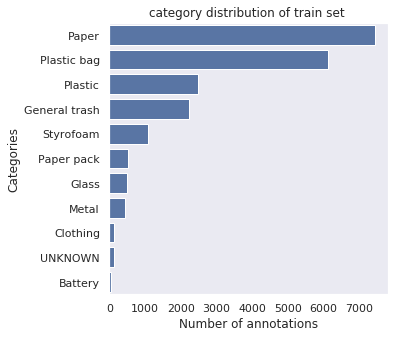

In [8]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [9]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [10]:
# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


## 데이터 전처리 함수 정의 (Dataset)

In [11]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [12]:
#K-fold를 위한 dataset 경로 설정 & dataset 설정 & data loader 설정

## transform
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                            A.HorizontalFlip(p=0.3),
                            A.Rotate(p=0.3, limit=45),
                            A.Cutout(num_holes=4, max_h_size=20, max_w_size=20),
                            A.RandomBrightnessContrast(p=0.3),
                            A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25), max_pixel_value=255.0, p=1.0),
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])


##train, val
kfold_train_loader = []; kfold_val_loader = []
for i in range(n_splits) : 
  train_path = dataset_path+'/train_data'+str(i)+'.json'
  val_path = dataset_path+'/valid_data'+str(i)+'.json'
  # dataset
  train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)
  val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)
  # data loader
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn,
                                           drop_last=True,
                                           pin_memory=True)
  kfold_train_loader.append(train_loader)

  val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn,
                                         drop_last=True,
                                         pin_memory=True)
  kfold_val_loader.append(val_loader)

#test
test_path = dataset_path + '/test.json'
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=test_batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn,
                                          pin_memory=True)


loading annotations into memory...
Done (t=3.44s)
creating index...
index created!
loading annotations into memory...
Done (t=1.50s)
creating index...
index created!
loading annotations into memory...
Done (t=3.41s)
creating index...
index created!
loading annotations into memory...
Done (t=1.82s)
creating index...
index created!
loading annotations into memory...
Done (t=3.30s)
creating index...
index created!
loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
loading annotations into memory...
Done (t=4.62s)
creating index...
index created!
loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
loading annotations into memory...
Done (t=3.38s)
creating index...
index created!
loading annotations into memory...
Done (t=2.70s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

In [11]:
'''
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()
'''

'\n# train_loader의 output 결과(image 및 mask) 확인\nfor imgs, masks, image_infos in train_loader:\n    image_infos = image_infos[0]\n    temp_images = imgs\n    temp_masks = masks\n    \n    break\n\nfig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))\n\nprint(\'image shape:\', list(temp_images[0].shape))\nprint(\'mask shape: \', list(temp_masks[0].shape))\nprint(\'Unique values, category of transformed mask : \n\', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])\n\nax1.imshow(temp_images[0].permute([1,2,0]))\nax1.grid(False)\nax1.set_title("input image : {}".format(image_infos[\'file_name\']), fontsize = 15)\n\nax2.imshow(temp_masks[0])\nax2.grid(False)\nax2.set_title("masks : {}".format(image_infos[\'file_name\']), fontsize = 15)\n\nplt.show()\n'

In [12]:
'''
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()
'''

'\n# val_loader의 output 결과(image 및 mask) 확인\nfor imgs, masks, image_infos in val_loader:\n    image_infos = image_infos[0]\n    temp_images = imgs\n    temp_masks = masks\n    \n    break\n\nfig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))\n\nprint(\'image shape:\', list(temp_images[0].shape))\nprint(\'mask shape: \', list(temp_masks[0].shape))\n\nprint(\'Unique values, category of transformed mask : \n\', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])\n\nax1.imshow(temp_images[0].permute([1,2,0]))\nax1.grid(False)\nax1.set_title("input image : {}".format(image_infos[\'file_name\']), fontsize = 15)\n\nax2.imshow(temp_masks[0])\nax2.grid(False)\nax2.set_title("masks : {}".format(image_infos[\'file_name\']), fontsize = 15)\n\nplt.show()\n'

In [13]:
'''
# test_loader의 output 결과(image 및 mask) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    # temp_masks = masks
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()
'''

'\n# test_loader의 output 결과(image 및 mask) 확인\nfor imgs, image_infos in test_loader:\n    image_infos = image_infos[0]\n    temp_images = imgs\n    # temp_masks = masks\n    \n    break\n\nfig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))\n\nprint(\'image shape:\', list(temp_images[0].shape))\n\nax1.imshow(temp_images[0].permute([1,2,0]))\nax1.grid(False)\nax1.set_title("input image : {}".format(image_infos[\'file_name\']), fontsize = 15)\n\nplt.show()\n'

## baseline model


### <font color='blue'>[TODO] 정답 코드 구현 DeepLabv3 (VGG16) </font>

In [14]:
'''
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
model = DeepLabV3(n_classes=12, n_blocks=[3, 4, 23, 3], atrous_rates=[6, 12, 18, 24])

x = torch.randn([2, 3, 512, 512])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)
'''

'\n# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test\nmodel = DeepLabV3(n_classes=12, n_blocks=[3, 4, 23, 3], atrous_rates=[6, 12, 18, 24])\n\nx = torch.randn([2, 3, 512, 512])\nprint("input shape : ", x.shape)\nout = model(x).to(device)\nprint("output shape : ", out.size())\n\nmodel = model.to(device)\n'

## segmentation models 이용
### 주소 : https://github.com/qubvel/segmentation_models.pytorch

### DeepLabV3

In [13]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3(
    encoder_name=model_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=pretrained_name,     # use `imagenet` pre-trained weights for encoder initialization

    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)
model = model.to(device)

## Wandb setting

In [16]:
#config - no scheduler
wandb.init(group=group_name, project='gjtak', config=cosine_config)
#config - scheduler
#wandb.init(group=group_name, project='gjtak', config=steplr_config)
wandb.run.name = ('D3_'+ model_name + "_" + pretrained_name + '_' + criterion_name + '_' + optimizer_name + '_' + scheduler_name +'_'+ augmentation_type)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pstage12 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.29 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## train, validation, test 함수 정의

In [17]:
def train(num_epochs, model, kfold_data_loader, target_val_loader, criterion, optimizer, saved_dir, val_every, device, scheduler=None):
    print('Start training..')
    best_loss = 9999999
    for epoch in range(num_epochs):
        model.train()
        loss_value = 0
        for idx, data_loader in enumerate(kfold_data_loader) : 
            #한 개의 fold 에 대해 수행
            for step, (images, masks, _) in enumerate(data_loader):
                images = torch.stack(images)       # (batch, channel, height, width)
                masks = torch.stack(masks).long()  # (batch, channel, height, width)
                
                # gpu 연산을 위해 device 할당
                images, masks = images.to(device), masks.to(device)
                      
                # inference
                outputs = model(images)
                
                # loss 계산 (cross entropy loss)
                loss = criterion(outputs, masks)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_value += loss.item()

                # step 주기에 따른 loss 출력
                if (step + 1) % 25 == 0:
                    train_loss = loss_value / 25;
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                        epoch+1, num_epochs, step+1, len(train_loader), train_loss))
                    #wandb
                    wandb.log({"Train loss": float(train_loss)})
                    loss_value = 0  #초기화
            
            #scheduler
            if scheduler != None :
                scheduler.step()
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, target_val_loader, criterion, device)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                wandb.log({"Best loss": float(best_loss)})
                save_model(model, saved_dir)

In [18]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch))
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)

            images, masks = images.to(device), masks.to(device)            

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()

            mIoU = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)[2]
            mIoU_list.append(mIoU)
            
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}'.format(epoch, avrg_loss, np.mean(mIoU_list)))
        wandb.log({"avrg_loss" : avrg_loss, "mIoU":np.mean(mIoU_list)})
    return avrg_loss

## 모델 저장 함수 정의

In [16]:
# 모델 저장 함수 정의
val_every = 1
#saved_file_name='D3_best_model'
#steplr_config_str = '_(step'+str(steplr_step_size)+'_gamma_'+str(steplr_gamma)+')' # scheduler 적용
#steplr_config_str = "" #scheduler 적용 X
coslr_config_str = '_(T_max'+str(cos_T_max)+'_eta_min_'+str(cos_eta_min)+')' # scheduler 적용
file_scheduler_name = scheduler_name + coslr_config_str
adam_config_str = 'learning_rate('+str(learning_rate)+'_adam_weight_decay('+str(adam_weight_decay)+')'
file_optimizer_name = optimizer_name + adam_config_str
#softcross_config_str = '_(smooth_factor('+str(softCross_smooth_factor)+')_ignore_idx('+\
#                       str(softCross_ignore_index)+')_dim('+str(softCross_dim)+')'

file_criterion_name = criterion_name

saved_file_name = ('D3_'+ model_name + "_" + pretrained_name + '_' + file_criterion_name + '_' + \
                   file_optimizer_name + '_' + file_scheduler_name +'_'+ augmentation_type)
saved_dir = '/opt/ml/code/saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name=saved_file_name+'.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [20]:
# Loss function 정의
criterion = nn.CrossEntropyLoss()
#focal loss
#criterion = FocalLoss(alpha=1, gamma=2)#2,5

# Optimizer 정의
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=adam_weight_decay)
# Scheduler 정의
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=steplr_step_size, gamma=steplr_gamma)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cos_T_max, eta_min=cos_eta_min)
#scheduler = None

## Wandb watch

In [21]:
wandb.watch(model, criterion, log="all")

In [22]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
#train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)
for idx in range(n_splits) : 
  print(str(idx+1)+"번째 fold 진행...\n")
  kfold_data_loader = [loader for seq, loader in enumerate(kfold_train_loader) if idx != seq]
  target_val_loader = kfold_val_loader[idx]
  #학습 진행
  train(num_epochs, model, kfold_data_loader, target_val_loader, \
        criterion, optimizer, saved_dir, val_every, device, scheduler)
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()
print("<<<total train_time>>>")
print(start.elapsed_time(end))

1번째 fold 진행...

Start training..
Epoch [1/5], Step [25/655], Loss: 1.6424
Epoch [1/5], Step [50/655], Loss: 1.1593
Epoch [1/5], Step [75/655], Loss: 1.0020
Epoch [1/5], Step [100/655], Loss: 0.8507
Epoch [1/5], Step [125/655], Loss: 0.8811
Epoch [1/5], Step [150/655], Loss: 0.7894
Epoch [1/5], Step [175/655], Loss: 0.7030
Epoch [1/5], Step [200/655], Loss: 0.6406
Epoch [1/5], Step [225/655], Loss: 0.6784
Epoch [1/5], Step [250/655], Loss: 0.6034
Epoch [1/5], Step [275/655], Loss: 0.6087
Epoch [1/5], Step [300/655], Loss: 0.6112
Epoch [1/5], Step [325/655], Loss: 0.5897
Epoch [1/5], Step [350/655], Loss: 0.5326
Epoch [1/5], Step [375/655], Loss: 0.5151
Epoch [1/5], Step [400/655], Loss: 0.5763
Epoch [1/5], Step [425/655], Loss: 0.5273
Epoch [1/5], Step [450/655], Loss: 0.5438
Epoch [1/5], Step [475/655], Loss: 0.5268
Epoch [1/5], Step [500/655], Loss: 0.4794
Epoch [1/5], Step [525/655], Loss: 0.4581
Epoch [1/5], Step [550/655], Loss: 0.5384
Epoch [1/5], Step [575/655], Loss: 0.5143
Epoc

KeyboardInterrupt: 

## 저장된 model 불러오기 (학습된 이후) 

In [18]:
# best model 저장된 경로
#model_path = '/opt/ml/code/saved/UnetPP_best_model.pt'
#model_path = '/opt/ml/code/saved/'+saved_file_name+'.pt'
model_path = '/opt/ml/code/saved/D3_efficientnet-b4_imagenet_SoftCrossEntropy_adam_CosineAnnealingLR_HF_Rotate_RBC_1fold.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
#model.eval()

RuntimeError: [enforce fail at inline_container.cc:145] . PytorchStreamReader failed reading zip archive: failed finding central directory

In [ ]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 2
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

## submission을 위한 test 함수 정의

### 일반 test 

In [ ]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(test_loader):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
            if (step + 1) % 25 == 0:
                print('Step [{}/{}]'.format(step+1, len(train_loader)))
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

### TTA 활용 test

In [ ]:
def TTA_test(model, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    tta_test_transform = A.Compose([
                            A.HorizontalFlip(p=0.3),
                            A.Rotate(p=0.3, limit=45),
                            #A.Cutout(num_holes=4, max_h_size=20, max_w_size=20),
                            A.RandomBrightnessContrast(p=0.3),
                            #A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25), max_pixel_value=255.0, p=1.0),
                            ToTensorV2()
                            ])
    #test
    tta_test_path = dataset_path + '/test.json'
    tta_test_dataset = CustomDataLoader(data_dir=tta_test_path, mode='test', \
                                        transform=tta_test_transform)
    tta_test_loader = torch.utils.data.DataLoader(dataset=tta_test_dataset,
                                          batch_size=test_batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn,
                                          pin_memory=True)




    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tta_test_loader):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
            if (step + 1) % 25 == 0:
                print('Step [{}/{}]'.format(step+1, len(train_loader)))
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

# sample_submisson.csv 열기
submission = pd.read_csv('/opt/ml/code/submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)


final_file_name = 'Baseline_D3_'+ model_name + "_" + pretrained_name + '_' + file_criterion_name + '_' + \
                    file_optimizer_name + '_' + file_scheduler_name + "_"+augmentation_type
submission.to_csv("/opt/ml/code/submission/"+ final_file_name+ ".csv", index=False)

end.record()

# Waits for everything to finish running
torch.cuda.synchronize()
print("<<<total inference_time>>>")
print(start.elapsed_time(end))


## Reference

